In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import logging

logger = logging.getLogger('')
logger.setLevel(logging.INFO)


In [2]:
class Model(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        p_hidden_size = 100
        l_hidden_size = 100
        hidden_size = 100

        hdim = obs_dim // (act_dim+1)

        self.participant_branch = nn.Sequential(
            nn.Linear(hdim * act_dim, p_hidden_size),
            nn.ReLU()
        )

        self.loss_branch = nn.Sequential(
            nn.Linear(hdim, l_hidden_size),
            nn.ReLU()
        )

        self.merge = nn.Sequential(
            nn.Linear(p_hidden_size + l_hidden_size, hidden_size),
            nn.ReLU()
        )
    
    def transfer(self, x):
        p = x[..., :-1]
        l = x[..., -1:]
        return p.reshape(p.size(0), -1), l.reshape(l.size(0), -1)
    def forward(self, x):
        p, l = self.transfer(x)
        pb = self.participant_branch(p)
        lb = self.loss_branch(l)
        x = torch.cat([pb, lb], dim=-1)
        return self.merge(x)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ResidualBlock, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        residual = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x += residual  # 跳跃连接
        x = self.relu(x)
        return x

class ModelRes(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        p_hidden_size = 50
        l_hidden_size = 50
        hidden_size = 50
        num_blocks = 2
        hdim = obs_dim // (act_dim+1)

        self.participant_branch = nn.Sequential(
            nn.Linear(hdim * act_dim, p_hidden_size),
            nn.ReLU()
        )
        self.loss_branch = nn.Sequential(
            nn.Linear(hdim, l_hidden_size),
            nn.ReLU()
        )
        self.merge = nn.Sequential(
            nn.Linear(p_hidden_size + l_hidden_size, hidden_size),
            nn.ReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)])
        self.net = nn.Sequential(
            self.merge,
            self.res_blocks,
            nn.Linear(hidden_size, act_dim),
            # nn.Softmax(dim=1),
        )
    def transfer(self, x):
        p = x[..., :-1]
        l = x[..., -1:]
        return p.reshape(p.size(0), -1), l.reshape(l.size(0), -1)
    def forward(self, obs):
        p, l = self.transfer(obs)
        pb = self.participant_branch(p)
        lb = self.loss_branch(l)
        obs = torch.cat([pb, lb], dim=-1)
        return self.net(obs)

class ModelResSoft(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        p_hidden_size = 50
        l_hidden_size = 50
        hidden_size = 50
        num_blocks = 2
        hdim = obs_dim // (act_dim+1)

        self.participant_branch = nn.Sequential(
            nn.Linear(hdim * act_dim, p_hidden_size),
            nn.ReLU()
        )
        self.loss_branch = nn.Sequential(
            nn.Linear(hdim, l_hidden_size),
            nn.ReLU()
        )
        self.merge = nn.Sequential(
            nn.Linear(p_hidden_size + l_hidden_size, hidden_size),
            nn.ReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)])
        self.net = nn.Sequential(
            self.merge,
            self.res_blocks,
            nn.Linear(hidden_size, act_dim),
            nn.Softmax(dim=1),
        )
    def transfer(self, x):
        p = x[..., :-1]
        l = x[..., -1:]
        return p.reshape(p.size(0), -1), l.reshape(l.size(0), -1)
    def forward(self, obs):
        p, l = self.transfer(obs)
        pb = self.participant_branch(p)
        lb = self.loss_branch(l)
        obs = torch.cat([pb, lb], dim=-1)
        return self.net(obs)

In [4]:
from helper import Camera
import pickle
import scipy

In [5]:
def spearmanFromActProb(rank, act_prob):
    x = [act_prob[i] for i in rank]
    y = [c for c in range(len(rank))]
    return scipy.stats.spearmanr(x,y)[0]
def spearmanSequenceFromActProbList(rank, act_probList):
    cos = []
    for act_prob in act_probList:
        cos.append(spearmanFromActProb(rank, act_prob))
    return np.array(cos)
def evaluateContributionsFromLogs(logs, client_nums):
    contirbution = []
    ddl = len(logs)
    for r in range(ddl):
        contirbution.append([0 for c in range(client_nums)])
    pprev_acc = logs[0].acc
    prev_participants = logs[1].participants
    prev_acc = logs[1].acc
    for r in range(2, ddl):
        for c in range(client_nums):
            contirbution[r][c] = contirbution[r-1][c]
        participants, acc = logs[r].participants, logs[r].acc
        if acc - prev_acc > prev_acc - pprev_acc:
            for c in prev_participants:
                contirbution[r][c] -= 1
            for c in participants:
                contirbution[r][c] += 1
        
        if acc < prev_acc:
            for c in participants:
                contirbution[r][c] -= 1
    return contirbution

In [8]:
with open('camera/cn100_pn10_dFMNIST_aMLP_plabel-skew_seed5.camera', 'rb') as f:
    camera = pickle.load(f)
curr_round = 4
act_probs = camera.act_probLogs[curr_round]
contributions = evaluateContributionsFromLogs(camera.getRpmLogs(curr_round), camera.client_nums)
sco_rl = spearmanSequenceFromActProbList(camera.rank, act_probs)
sco_qi = spearmanSequenceFromActProbList(camera.rank, contributions)
sco_rl[199], sco_qi[199]

(0.537303229220732, -0.2544619486746213)

In [17]:
sco_rl[199], sco_qi[199]

(0.9999999999999999, 0.9999999999999999)

In [18]:
log = rpm.buffer[r]
log.acc, log.loss, log.participants

NameError: name 'rpm' is not defined

In [ ]:

logs = [rpm.buffer[i] for i in range(8, 209)]
contributions = evaluateContributionsFromLogs(logs, camera.client_nums)

In [ ]:

s1 = spearmanFromActProb(camera.rank, contributions[199])
s2 = spearmanFromActProb(camera.rank, camera.act_probLogs[curr_round][199])
s1, s2

(0.4146991669867845, 0.48400840084008395)

In [ ]:
bs = 2
act_dim = 3
h_dim = 2
obs_dim = (act_dim + 1) * h_dim
print(obs_dim)
m1 = ModelRes(obs_dim=obs_dim, act_dim=act_dim)
m2 = ModelResSoft(obs_dim=obs_dim, act_dim=act_dim)

8


In [ ]:
x = torch.randn([bs,1 , h_dim, act_dim+1])
p = m1(x)
soft1 = nn.Softmax(dim=1)
soft2 = F.softmax
p1 = soft1(p)
p2 = soft2(p, dim=-1)
p1, p2

(tensor([[0.2650, 0.4232, 0.3119],
         [0.2331, 0.4504, 0.3166]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.2650, 0.4232, 0.3119],
         [0.2331, 0.4504, 0.3166]], grad_fn=<SoftmaxBackward0>))

In [ ]:
F.softmax(p1,dim=1)

tensor([[0.2851, 0.4292, 0.2857],
        [0.3004, 0.3787, 0.3209]], grad_fn=<SoftmaxBackward0>)

In [ ]:
l = [i for i in range(0, 32)]

In [ ]:
l[-64:]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [ ]:
f = nn.BCEWithLogitsLoss(reduction='none')
g = nn.BCEWithLogitsLoss()

In [ ]:
f(pred, one_hots), g(pred, one_hots)

(tensor([[0.7762, 0.7756, 0.8213],
         [0.6489, 0.6156, 0.8133]],
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.7418, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))

In [ ]:
t = f(pred, one_hots)

tensor([[0.7762, 0.7756, 0.8213],
        [0.6489, 0.6156, 0.8133]],
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
rewards

tensor([[-0.9001],
        [-0.2279]])

In [ ]:
t * rewards

tensor([[-0.6986, -0.6981, -0.7392],
        [-0.1479, -0.1403, -0.1853]], grad_fn=<MulBackward0>)

In [ ]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


from fedlab.utils.dataset.partition import CIFAR100Partitioner
from fedlab.utils.dataset import functional as F
from fedlab.utils.functional import partition_report


In [ ]:
trainset = torchvision.datasets.CIFAR10(root="/root/autodl-tmp/datasets2", train=True, download=True)

Files already downloaded and verified


In [53]:
num_clients = 100
num_classes = 100
num_display_classes = 10


col_names = [f"class{i}" for i in range(num_classes)]
display_col_names = [f"class{i}" for i in range(num_display_classes)]

seed = 2021

hist_color = '#4169E1'
plt.rcParams['figure.facecolor'] = 'white'

In [54]:
# perform partition
hetero_dir_part = CIFAR100Partitioner(trainset.targets, 
                                num_clients,
                                balance=None,
                                partition="dirichlet",
                                dir_alpha=0.5,
                                # unbalance_sgm=0.3,
                                seed=2020)
# save to pkl file
torch.save(hetero_dir_part.client_dict, "tpm.pkl")
print(len(hetero_dir_part))

100


Text(0.5, 0, 'sample num')

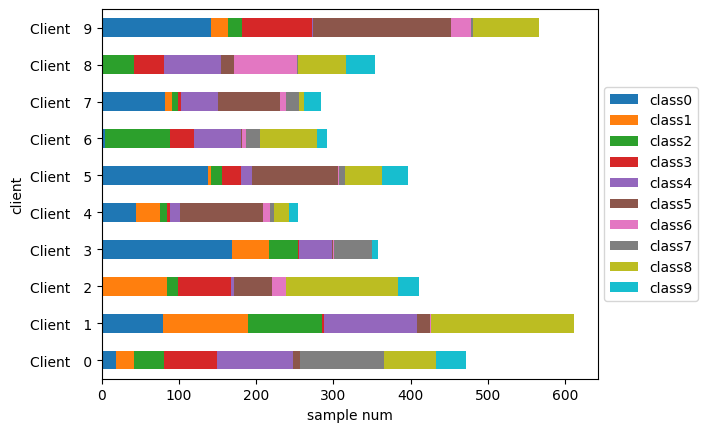

In [55]:
# generate partition report
csv_file = "tpm.csv"
partition_report(trainset.targets, hetero_dir_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

hetero_dir_part_df = pd.read_csv(csv_file,header=1)
hetero_dir_part_df = hetero_dir_part_df.set_index('client')
for col in col_names:
    hetero_dir_part_df[col] = (hetero_dir_part_df[col] * hetero_dir_part_df['Amount']).astype(int)

# select first 10 clients and first 10 classes for bar plot
hetero_dir_part_df[display_col_names].iloc[:10].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
# plt.savefig(f"./imgs/cifar100_hetero_dir_0.3_100clients.png", dpi=400, bbox_inches = 'tight')

In [46]:
from fedlab.utils.dataset.partition import MNISTPartitioner

num_classes = 10
num_clients = 25
seed = 2021


noniid_labeldir_part = MNISTPartitioner(trainset.targets, 
                                        num_clients=num_clients,
                                        partition="noniid-labeldir", 
                                        dir_alpha=0.5,
                                        seed=seed)

Text(0.5, 0, 'sample num')

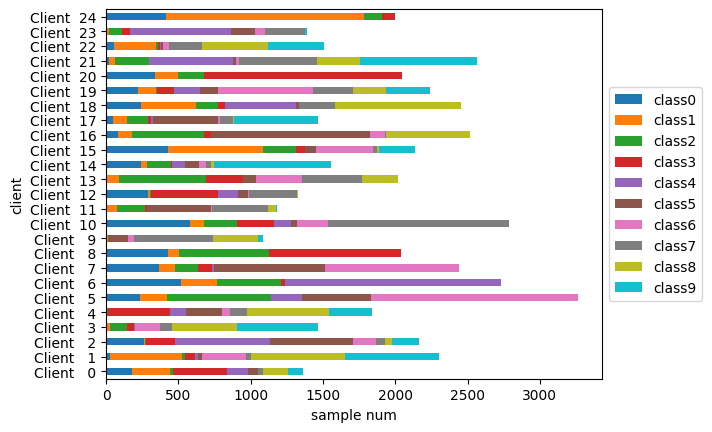

In [47]:
col_names = [f"class{i}" for i in range(num_classes)]

hist_color = '#4169E1'
plt.rcParams['figure.facecolor'] = 'white'

# generate partition report
csv_file = "tpm.csv"
partition_report(trainset.targets, noniid_labeldir_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

noniid_labeldir_part_df = pd.read_csv(csv_file,header=1)
noniid_labeldir_part_df = noniid_labeldir_part_df.set_index('client')
for col in col_names:
    noniid_labeldir_part_df[col] = (noniid_labeldir_part_df[col] * noniid_labeldir_part_df['Amount']).astype(int)

# select first 10 clients for bar plot
noniid_labeldir_part_df[col_names].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')